<a href="https://colab.research.google.com/github/krissme28/-studying_ML/blob/main/2_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

In [ ]:
# Загрузка данных Fashion-MNIST
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Нормализация данных и добавление размерности канала (1, так как изображения одноканальные)
#-1: Это специальное значение, которое используется для автоматического вычисления размерности входных данных
#28: Это размерность для высоты и ширины изображения.
X_train = X_train.reshape((-1, 28, 28, 1)) / 255.0
X_test = X_test.reshape((-1, 28, 28, 1)) / 255.0

# Преобразование меток классов в формат one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# Создание и обучение сверточной нейронной сети
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(10, activation="softmax"))

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 40s 26ms/step - loss: 0.4779 - accuracy: 0.8249 - val_loss: 0.3539 - val_accuracy: 0.8726
Epoch 2/10
1500/1500 [==============================] - 32s 21ms/step - loss: 0.3161 - accuracy: 0.8848 - val_loss: 0.3140 - val_accuracy: 0.8848
Epoch 3/10
1500/1500 [==============================] - 33s 22ms/step - loss: 0.2703 - accuracy: 0.8996 - val_loss: 0.2917 - val_accuracy: 0.8938
Epoch 4/10
1500/1500 [==============================] - 32s 21ms/step - loss: 0.2355 - accuracy: 0.9134 - val_loss: 0.2636 - val_accuracy: 0.9022
Epoch 5/10
1500/1500 [==============================] - 32s 21ms/step - loss: 0.2066 - accuracy: 0.9233 - val_loss: 0.2614 - val_accuracy: 0.9047
Epoch 6/10
1500/1500 [==============================] - 31s 21ms/step - loss: 0.1830 - accuracy: 0.9320 - val_loss: 0.2478 - val_accuracy: 0.9122
Epoch 7/10
1500/1500 [==============================] - 32s 21ms/step - loss: 0.1628 - accuracy: 0.9390 - val_loss: 0.2506 -

In [ ]:
# Функция для проведения атаки отравления
def generate_backdoor(X_clean, y_clean, percent_poison, target_class):
    n_clean = X_clean.shape[0]
    num_poison = round((percent_poison * n_clean) / (1 - percent_poison))

    # Выбираем случайные индексы для отравления
    poison_indices = np.random.choice(n_clean, num_poison, replace=False)

    # Создаем копии отравляющих образцов
    X_poison = X_clean[poison_indices].copy()
    y_poison = y_clean[poison_indices].copy()

    # Задаем отравляющий класс
    target_class = target_class

    # Меняем метки отравляющих образцов на целевой класс
    y_poison[:] = target_class

    # Добавляем отравленные образцы к исходному обучающему набору
    X_backdoor = np.concatenate((X_clean, X_poison), axis=0)
    y_backdoor = np.concatenate((y_clean, y_poison), axis=0)

    return X_backdoor, y_backdoor

In [ ]:
# Оцениваем производительность модели на тестовых данных до атаки
y_pred_before_attack = model.predict(X_test)
accuracy_before_attack = np.mean(np.argmax(y_pred_before_attack, axis=1) == np.argmax(y_test, axis=1))
print("Точность на тестовых данных до атаки: %.2f%%" % (accuracy_before_attack * 100))

313/313 [==============================] - 2s 6ms/step
Точность на тестовых данных до атаки: 91.16%


Примеры изображений, где нейросеть правильно определяет классы до атаки:


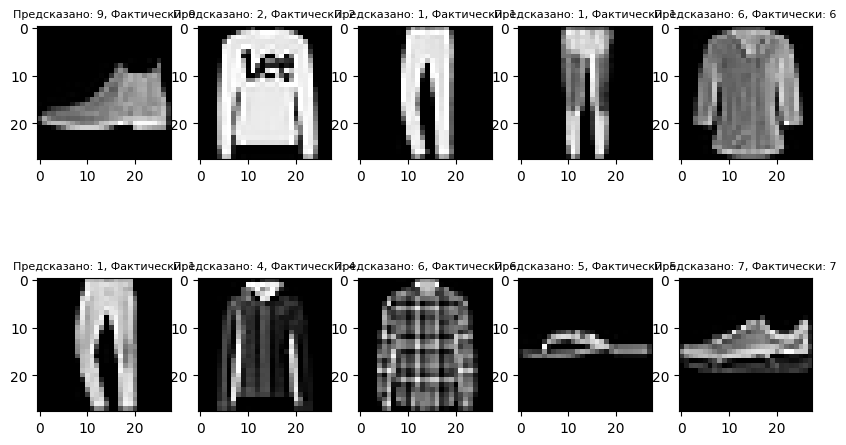

In [ ]:
# Выводим примеры изображений, где нейросеть правильно определяет классы до атаки
print("Примеры изображений, где нейросеть правильно определяет классы до атаки:")
fig, axs = plt.subplots(2, 5, figsize=(10, 6))
for i in range(10):
    axs[i // 5, i % 5].imshow(X_test[i].reshape(28, 28), cmap='gray')
    pred_class = np.argmax(y_pred_before_attack[i])
    true_class = np.argmax(y_test[i])
    axs[i // 5, i % 5].set_title(f"Предсказано: {pred_class}, Фактически: {true_class}", fontsize=8)
plt.show()

In [ ]:
# Вызываем функцию атаки отравления с процентом отравления 10% и целевым классом 1
percent_poison = 0.1
target_class = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])  # Пример: целевой класс - 1, остальные - 0
X_train_poisoned, y_train_poisoned = generate_backdoor(X_train, y_train, percent_poison, target_class)

In [ ]:
# Создаем список для хранения точности на каждой эпохе обучения с отравлением
accuracy_history = []
# Обучаем модель на отравленных данных и записываем точность на каждой эпохе
for epoch in range(10):
    model.fit(X_train_poisoned, y_train_poisoned, epochs=1, batch_size=32, verbose=0)
    y_pred_poisoned = model.predict(X_test)
    accuracy_poisoned = np.mean(np.argmax(y_pred_poisoned, axis=1) == np.argmax(y_test, axis=1))
    accuracy_history.append(accuracy_poisoned)
    print("Эпоха %d, Точность на тестовых данных с отравлением: %.2f%%" % (epoch+1, accuracy_poisoned * 100))

313/313 [==============================] - 2s 6ms/step
Эпоха 1, Точность на тестовых данных с отравлением: 90.70%
313/313 [==============================] - 2s 5ms/step
Эпоха 2, Точность на тестовых данных с отравлением: 90.15%
313/313 [==============================] - 2s 6ms/step
Эпоха 3, Точность на тестовых данных с отравлением: 90.67%
313/313 [==============================] - 2s 6ms/step
Эпоха 4, Точность на тестовых данных с отравлением: 90.65%
313/313 [==============================] - 2s 8ms/step
Эпоха 5, Точность на тестовых данных с отравлением: 90.27%
313/313 [==============================] - 2s 7ms/step
Эпоха 6, Точность на тестовых данных с отравлением: 90.18%
313/313 [==============================] - 2s 6ms/step
Эпоха 7, Точность на тестовых данных с отравлением: 90.41%
313/313 [==============================] - 2s 6ms/step
Эпоха 8, Точность на тестовых данных с отравлением: 90.30%
313/313 [==============================] - 2s 7ms/step
Эпоха 9, Точность на тестовых дан

In [ ]:
# Оцениваем производительность модели на тестовых данных с отравлением
y_pred_poisoned = model.predict(X_test)
accuracy_poisoned = np.mean(np.argmax(y_pred_poisoned, axis=1) == np.argmax(y_test, axis=1))
print("Точность на тестовых данных с отравлением: %.2f%%" % (accuracy_poisoned * 100))

313/313 [==============================] - 2s 6ms/step
Точность на тестовых данных с отравлением: 88.54%


Примеры изображений, где нейросеть правильно определяет классы после атаки:


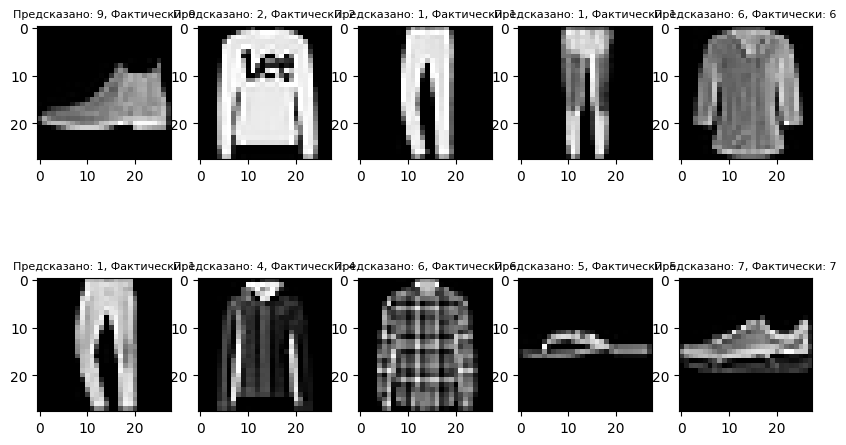

In [ ]:
# Выводим примеры изображений, где нейросеть правильно определяет классы после атаки
print("Примеры изображений, где нейросеть правильно определяет классы после атаки:")
fig, axs = plt.subplots(2, 5, figsize=(10, 6))
for i in range(10):
    axs[i // 5, i % 5].imshow(X_test[i].reshape(28, 28), cmap='gray')
    pred_class = np.argmax(y_pred_poisoned[i])
    true_class = np.argmax(y_test[i])
    axs[i // 5, i % 5].set_title(f"Предсказано: {pred_class}, Фактически: {true_class}", fontsize=8)
plt.show()

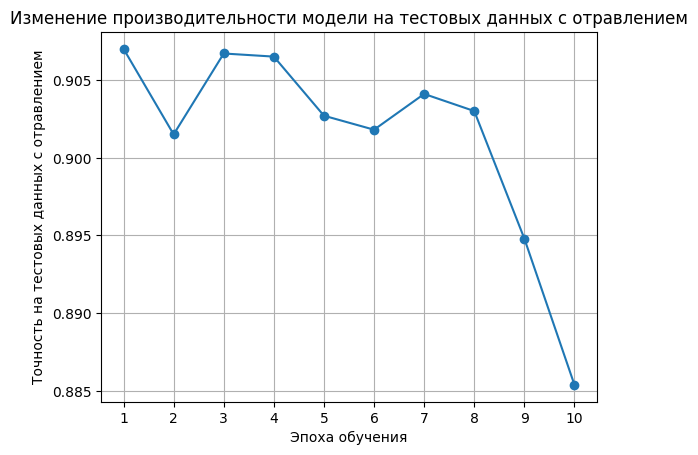

In [ ]:
# Отображаем график с изменением производительности модели на тестовых данных с отравлением
plt.plot(range(1, 11), accuracy_history, marker='o')
plt.xlabel('Эпоха обучения')
plt.ylabel('Точность на тестовых данных с отравлением')
plt.title('Изменение производительности модели на тестовых данных с отравлением')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()